# Hyperparameters

Consider the Booth test function (below). This function varies differently in different directions, and these directions are somewhat skewed with respect to the inputs. Our agent will automatically fit the right hyperparameters to account for this.

/home/thopkins1/Documents/public-repos/blop/.pixi/envs/dev/lib/python3.12/site-packages/databroker/assets/base_registry.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


Text(0, 0.5, 'x2')

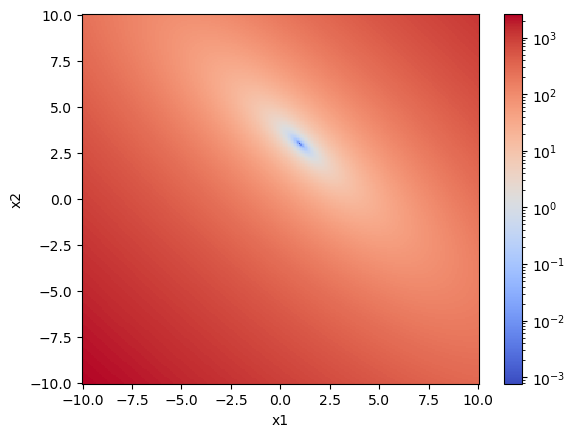

In [1]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

from blop.utils import functions

x1 = x2 = np.linspace(-10, 10, 256)
X1, X2 = np.meshgrid(x1, x2)

F = functions.booth(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(), shading="auto")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

The optimization goes faster if our model understands how the function changes as we change the inputs in different ways. The way it picks up on this is by starting from a general model that could describe a lot of functions, and making it specific to this one by choosing the right hyperparameters. Our Bayesian agent is very good at this, and only needs a few samples to figure out what the function looks like:

In [2]:
def digestion(df):
    df["booth"] = []
    for val_x1, val_x2 in zip(df.get("x1"), df.get("x2"), strict=False):
        df["booth"].append(functions.booth(val_x1, val_x2))
    return df

In [3]:
from datetime import datetime

import bluesky.plan_stubs as bps  # noqa F401
import bluesky.plans as bp  # noqa F401
import databroker  # type: ignore[import-untyped]
import matplotlib.pyplot as plt
import numpy as np
from bluesky.callbacks import best_effort
from bluesky.callbacks.tiled_writer import TiledWriter
from bluesky.run_engine import RunEngine
from databroker import Broker
from ophyd.utils import make_dir_tree  # type: ignore[import-untyped]
from tiled.client import from_uri  # type: ignore[import-untyped]
from tiled.server import SimpleTiledServer

from blop import DOF, Agent, Objective
from blop.sim import HDF5Handler

In [ ]:
tiled_server = SimpleTiledServer()
tiled_client = from_uri(tiled_server.uri)
tiled_writer = TiledWriter(tiled_client)


def setup_re_env(db_type="default", root_dir="/default/path", method="tiled"):
    RE = RunEngine({})
    bec = best_effort.BestEffortCallback()
    RE.subscribe(bec)
    _ = make_dir_tree(datetime.now().year, base_path=root_dir)

    if method.lower() == "tiled":
        RE.subscribe(tiled_writer)
        return {"RE": RE, "db": tiled_client, "bec": bec}

    elif method.lower() == "databroker":
        db = Broker.named(db_type)
        db.reg.register_handler("HDF5", HDF5Handler, overwrite=True)
        try:
            databroker.assets.utils.install_sentinels(db.reg.config, version=1)
        except Exception:
            pass
        RE.subscribe(db.insert)
        return {
            "RE": RE,
            "db": db,
            "bec": bec,
        }
    else:
        raise ValueError("The method for data storage used is not supported")


def register_handlers(db, handlers):
    for handler_spec, handler_class in handlers.items():
        db.reg.register_handler(handler_spec, handler_class, overwrite=True)


env = setup_re_env(db_type="temp", root_dir="/tmp/blop/sim", method="tiled")
globals().update(env)
bec.disable_plots()

2025-09-26 16:43:54.468 INFO: Subprocess stdout: 
2025-09-26 16:43:54.469 INFO: Subprocess stderr: Database sqlite+aiosqlite:////tmp/tmp7floa6cq/catalog.db is new. Creating tables.
Database initialized.

Tiled version 0.1.0b33
2025-09-26 16:43:54.604 INFO: Tiled version 0.1.0b33
2025-09-26 16:43:54.607 INFO: Context impl SQLiteImpl.
2025-09-26 16:43:54.607 INFO: Will assume non-transactional DDL.
2025-09-26 16:43:54.743 INFO: HTTP Request: GET http://127.0.0.1:35083/api/v1?api_key=fa51fa53ed5689cd "HTTP/1.1 307 Temporary Redirect"
2025-09-26 16:43:54.750 INFO: HTTP Request: GET http://127.0.0.1:35083/api/v1/ "HTTP/1.1 200 OK"
2025-09-26 16:43:54.775 INFO: HTTP Request: GET http://127.0.0.1:35083/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-09-26 16:43:54.781 INFO: HTTP Request: GET http://127.0.0.1:35083/api/v1/metadata/?include_data_sources=true "HTTP/1.1 200 OK"


2025-09-26 16:43:55.318 INFO: HTTP Request: GET http://127.0.0.1:35083/api/v1/table/partition/ee5214eb-5dba-44ac-ac6b-9e4c5b965206/streams/primary/internal?partition=0 "HTTP/1.1 200 OK"


In [5]:
dofs = [
    DOF(name="x1", search_domain=(-6, 6)),
    DOF(name="x2", search_domain=(-6, 6)),
]

objectives = [
    Objective(name="booth", target="min"),
]


agent = Agent(
    dofs=dofs,
    objectives=objectives,
    digestion=digestion,
    db=db,
)

RE(agent.learn(acqf="qr", n=16))

agent.plot_objectives()

/tmp/ipykernel_456812/3173933792.py:2: DeprecationWarning: The 'name' argument is deprecated and will be removed in Blop v1.0.0. The `movable.name` will be used instead.
  DOF(name="x1", search_domain=(-6, 6)),
/tmp/ipykernel_456812/3173933792.py:2: DeprecationWarning: The 'description' argument is deprecated and will be removed in Blop v1.0.0.
  DOF(name="x1", search_domain=(-6, 6)),
/tmp/ipykernel_456812/3173933792.py:2: DeprecationWarning: The 'travel_expense' argument is deprecated and will be removed in Blop v1.0.0. It may resurface in a future version.
  DOF(name="x1", search_domain=(-6, 6)),
/tmp/ipykernel_456812/3173933792.py:3: DeprecationWarning: The 'name' argument is deprecated and will be removed in Blop v1.0.0. The `movable.name` will be used instead.
  DOF(name="x2", search_domain=(-6, 6)),
/tmp/ipykernel_456812/3173933792.py:3: DeprecationWarning: The 'description' argument is deprecated and will be removed in Blop v1.0.0.
  DOF(name="x2", search_domain=(-6, 6)),
/tmp/i



Transient Scan ID: 1     Time: 2025-09-26 16:43:54
Persistent Unique Scan ID: 'ee5214eb-5dba-44ac-ac6b-9e4c5b965206'


2025-09-26 16:43:54.833 INFO: HTTP Request: POST http://127.0.0.1:35083/api/v1/metadata/ "HTTP/1.1 200 OK"
2025-09-26 16:43:54.845 INFO: HTTP Request: POST http://127.0.0.1:35083/api/v1/metadata//ee5214eb-5dba-44ac-ac6b-9e4c5b965206 "HTTP/1.1 200 OK"


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+


2025-09-26 16:43:54.982 INFO: HTTP Request: POST http://127.0.0.1:35083/api/v1/metadata//ee5214eb-5dba-44ac-ac6b-9e4c5b965206/streams "HTTP/1.1 200 OK"


|         1 | 16:43:54.9 |      1.728 |      0.204 |
|         2 | 16:43:54.9 |     -0.497 |      2.570 |
|         3 | 16:43:54.9 |      0.236 |      5.620 |
|         4 | 16:43:54.9 |     -2.030 |      3.254 |
|         5 | 16:43:54.9 |     -4.165 |      4.885 |
|         6 | 16:43:54.9 |     -5.675 |      1.291 |
|         7 | 16:43:54.9 |     -5.001 |     -0.687 |
|         8 | 16:43:54.9 |     -3.534 |     -5.864 |
|         9 | 16:43:54.9 |     -2.669 |     -3.762 |
|        10 | 16:43:55.0 |     -1.179 |     -1.687 |
|        11 | 16:43:55.0 |      1.065 |     -4.632 |
|        12 | 16:43:55.0 |      4.741 |     -3.731 |
|        13 | 16:43:55.0 |      3.233 |     -2.820 |
|        14 | 16:43:55.0 |      2.596 |     -0.818 |
|        15 | 16:43:55.0 |      4.091 |      1.923 |
|        16 | 16:43:55.0 |      5.560 |      4.253 |
+-----------+------------+------------+------------+
generator list_scan ['ee5214eb'] (scan num: 1)





2025-09-26 16:43:55.171 INFO: HTTP Request: POST http://127.0.0.1:35083/api/v1/metadata//ee5214eb-5dba-44ac-ac6b-9e4c5b965206/streams/primary "HTTP/1.1 200 OK"
2025-09-26 16:43:55.190 INFO: HTTP Request: PATCH http://127.0.0.1:35083/api/v1/table/partition//ee5214eb-5dba-44ac-ac6b-9e4c5b965206/streams/primary/internal?partition=0 "HTTP/1.1 200 OK"
2025-09-26 16:43:55.207 INFO: HTTP Request: PATCH http://127.0.0.1:35083/api/v1/metadata//ee5214eb-5dba-44ac-ac6b-9e4c5b965206?drop_revision=true "HTTP/1.1 200 OK"
2025-09-26 16:43:55.216 INFO: HTTP Request: GET http://127.0.0.1:35083/api/v1/metadata/ee5214eb-5dba-44ac-ac6b-9e4c5b965206 "HTTP/1.1 200 OK"
2025-09-26 16:43:55.226 INFO: HTTP Request: GET http://127.0.0.1:35083/api/v1/metadata/ee5214eb-5dba-44ac-ac6b-9e4c5b965206/streams "HTTP/1.1 200 OK"
2025-09-26 16:43:55.235 INFO: HTTP Request: GET http://127.0.0.1:35083/api/v1/metadata/ee5214eb-5dba-44ac-ac6b-9e4c5b965206/streams/primary "HTTP/1.1 200 OK"
2025-09-26 16:43:55.249 INFO: HTTP Re

TypeError: construct_single_task_model() got an unexpected keyword argument 'Y'

In addition to modeling the fitness of the task, the agent models the probability that an input will be feasible:

In [ ]:
agent.plot_acquisition(acqf="qei")

In [ ]:
RE(agent.learn("qei", n=4, iterations=4))
agent.plot_objectives()

In [ ]:
agent.best